In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

Load base config

In [124]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [125]:
cfg.output.project = 'msp300_smFISH'

cfg.run_name ='msp300_smFISH_3_3'
cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/msp300_smFISH_3.tif'
cfg.data_path.psf_path = None
cfg.ground_truth = None
cfg.microscope.psf_extent_zyx = [21,21,21]

cfg.bg_estimation.smoothing_filter_size = 3

cfg.foci.n_foci_avg = 2
cfg.microscope.psf_noise = 5e-4
cfg.microscope.multipl = 90
cfg.pointprocess.min_int = 0.15

cfg.autoencoder.opt.lr = 5e-5
cfg.autoencoder.norm_reg = 1

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,200:250,150:200,:]'
cfg.evaluation.px_size =  [100,100,100]

cfg.PSF.gauss_radii = [2.,1.0,1.0]

Store the config as an experiment

In [126]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [117]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Plot projections of the volume

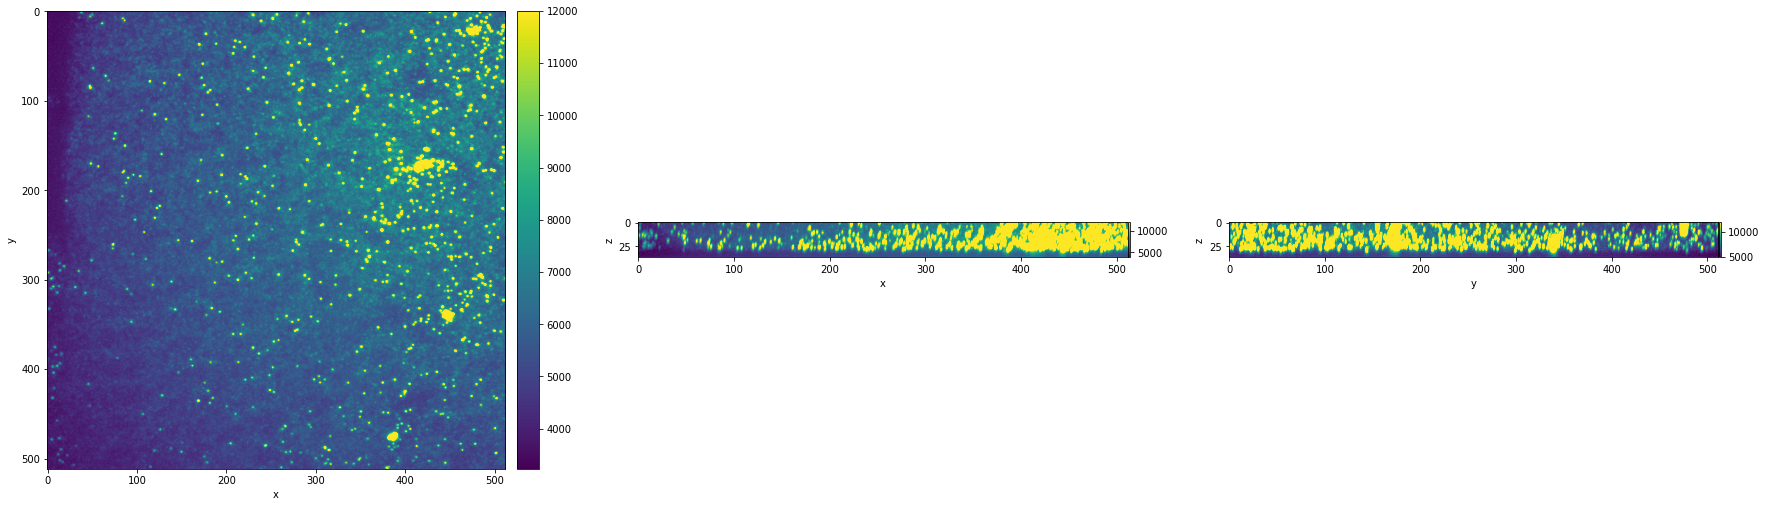

In [118]:
_ = plot_3d_projections(img_3d, projection='max', vmax=12000, size=10)

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

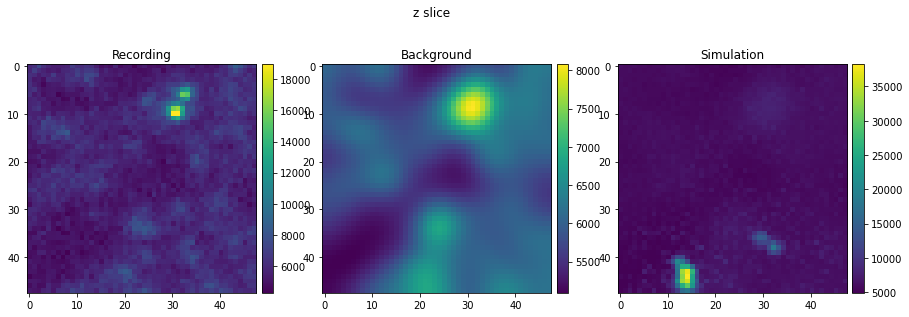

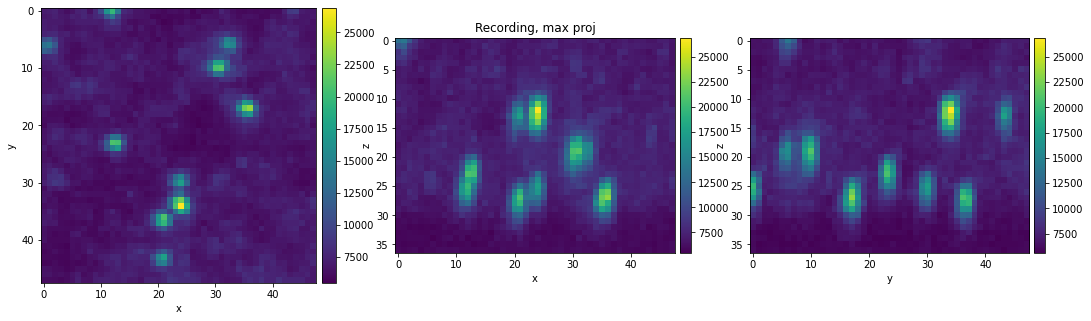

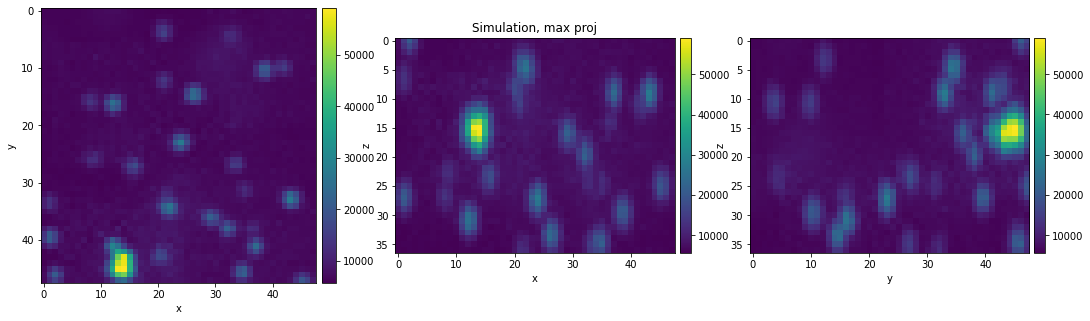

In [119]:
get_simulation_statistics(decode_dl, micro, int_threshold=1000)

Command to train a model on the gpu cluster

In [120]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ocodsub.log -e {home_dir}/logs/ecodesub.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ocodsub.log -e /groups/turaga/home/speisera/logs/ecodesub.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=msp300_smFISH_3_3'

# Evaluation

In [127]:
cfg = OmegaConf.load(f'config/experiment/msp300_smFISH_3_3.yaml')

In [128]:
print(cfg.microscope.psf_noise)
cfg.microscope.psf_noise = 0
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, cfg.output.save_dir, 'model.pkl')
psf_init, noise, micro = load_psf_noise_micro(cfg)
psf_init.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf_init.pkl'))

post_proc = load_post_proc(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

0.0005


<All keys matched successfully>

In [129]:
img_3d, decode_dl = get_dataloader(cfg)

Plot projections of the PSF before and after optimizing it during training

In [146]:
vol = psf.psf_volume[0]

In [137]:
psf_shape = psf_init.psf_volume.shape[-3:]
x_grid, y_grid, z_grid = torch.meshgrid(torch.arange(psf_shape[0]),torch.arange(psf_shape[1]),torch.arange(psf_shape[2]))
m_grid = torch.stack([x_grid, y_grid, z_grid], -1)

In [139]:
m_grid.shape

torch.Size([21, 21, 21, 3])

In [145]:
zc = (m_grid[:,:,:,0] * vol).sum()
yc = (m_grid[:,:,:,1] * vol).sum()
xc = (m_grid[:,:,:,2] * vol).sum()
print(zc,yc,xc)

tensor(10., grad_fn=<SumBackward0>) tensor(10., grad_fn=<SumBackward0>) tensor(10., grad_fn=<SumBackward0>)


In [147]:
zc = (m_grid[:,:,:,0] * vol).sum()
yc = (m_grid[:,:,:,1] * vol).sum()
xc = (m_grid[:,:,:,2] * vol).sum()
print(zc,yc,xc)

tensor(5.5319, grad_fn=<SumBackward0>) tensor(11.1120, grad_fn=<SumBackward0>) tensor(9.9877, grad_fn=<SumBackward0>)


array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

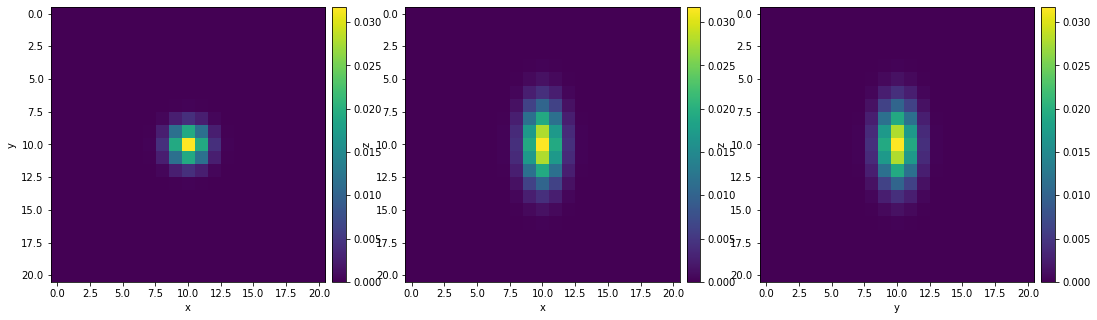

In [130]:
plot_3d_projections(psf_init.psf_volume[0],'max')

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

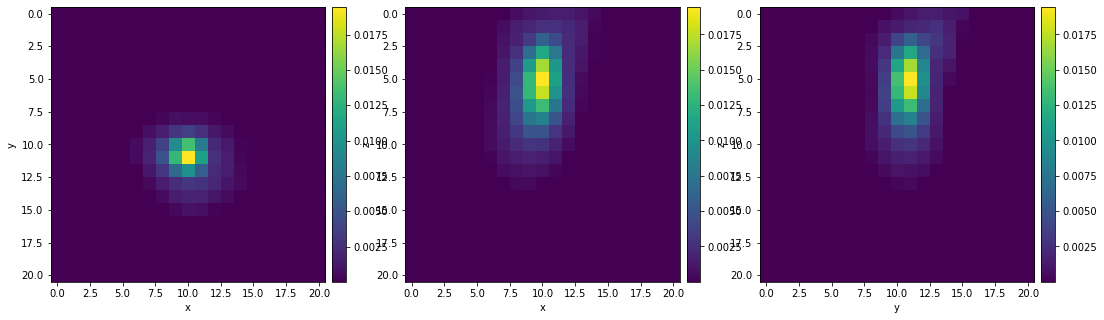

In [131]:
plot_3d_projections(psf.psf_volume[0],'max')

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

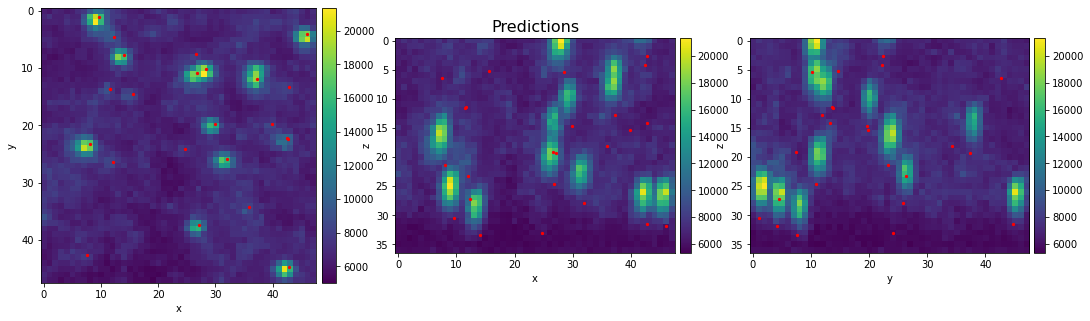

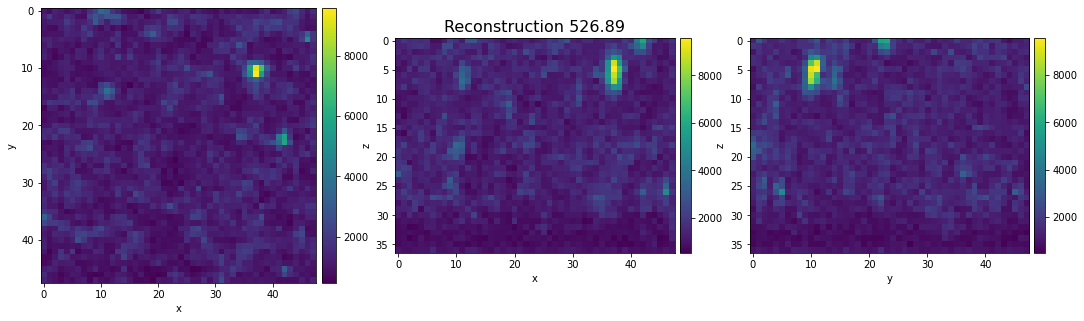

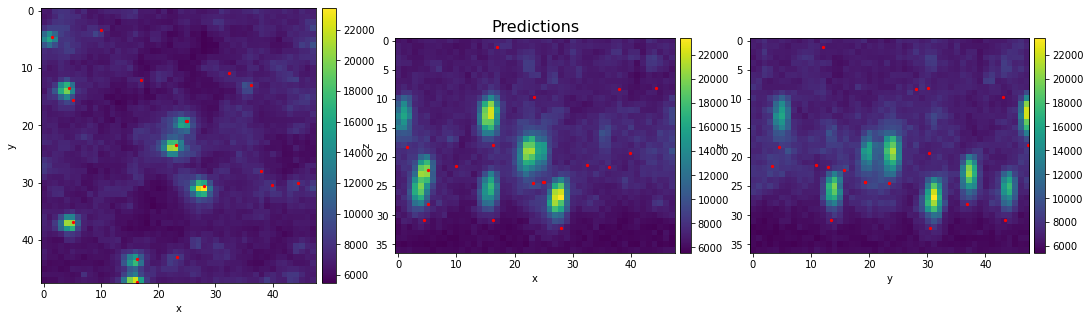

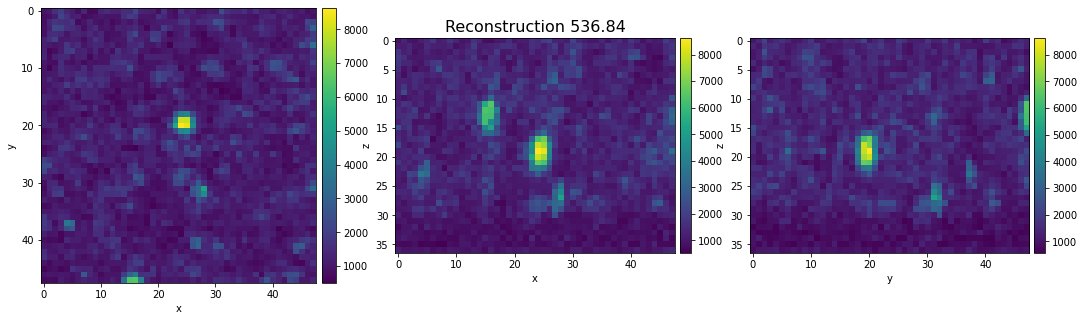

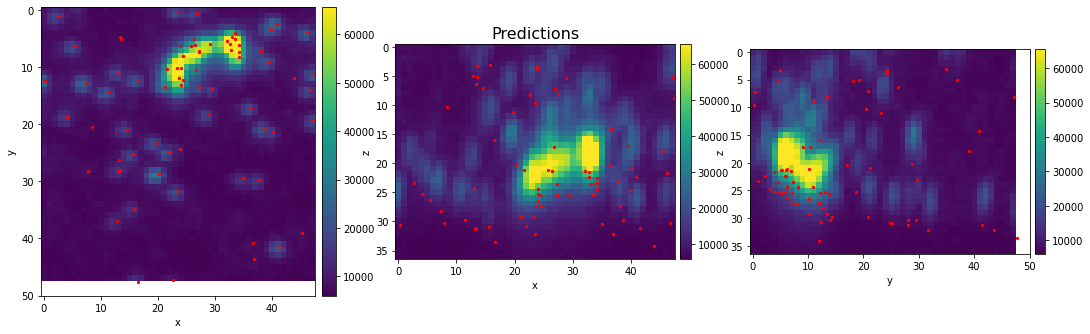

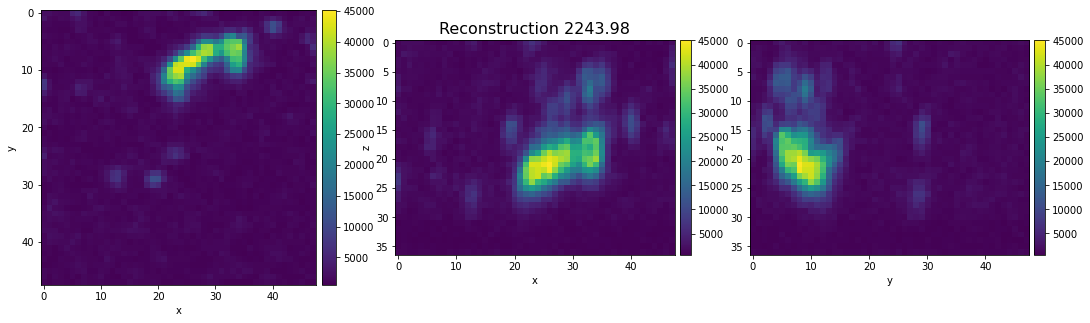

In [132]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3)

Volume with Foci? Max projection of real volume, reconstruction, difference

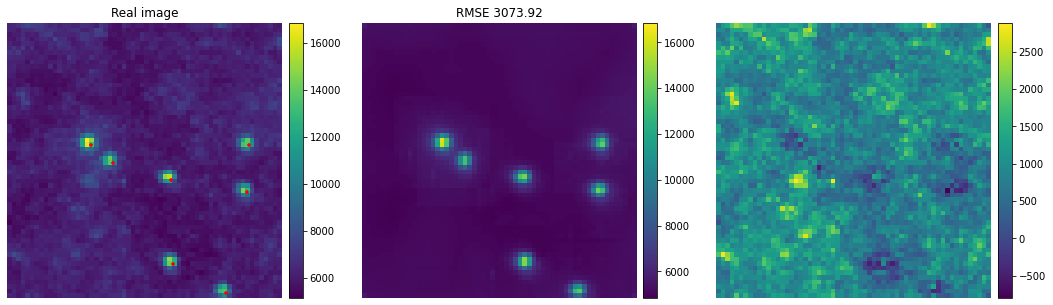

In [59]:
pred_df, gt_rec = get_prediction(model,img_3d[:,270:330,270:330], micro, return_rec=True, cuda=False)
_ = gt_plot(img_3d[:,270:330,270:330][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])

In [133]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[None,None])
    pred_df = model_output_to_df(res, 0.1, px_size=[100,100,100])
    free_mem()

NameError: name 'model_output_to_df' is not defined

Inferred intensities

In [ ]:
_ = plt.hist(pred_df['int'])

In [62]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red', size=1):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=size, marker='sphere', color=color)

3D rendering

In [ ]:
# vol = img_3d.numpy()

# extent = [[-s/2,s/2] for s in vol.shape]
# extent = [extent[i] for i in [2,1,0]]

# ipv.figure()
# ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
# scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'black', size=0.5)
# ipv.xyzlim(max(vol.shape)/2)
# ipv.view(90, 40)
# ipv.show()